In [1]:
import requests
import time

coin_id = "bitcoin"
url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range"

to_ts = int(time.time())                 
from_ts = to_ts - 90 * 24 * 60 * 60    

params = {    
    "vs_currency": "usd",
    "from": from_ts,
    "to": to_ts        
}

response = requests.get(url, params=params)
data = response.json()

print(data)

{'prices': [[1754604540095, 117166.47996245255], [1754607811455, 117596.49139855335], [1754611490877, 117466.18082017908], [1754615059212, 117310.75213931722], [1754618428371, 116881.55866056273], [1754622550600, 116755.37105082296], [1754625623065, 116742.99045895677], [1754629455771, 116766.05584500499], [1754633075218, 116572.41432240925], [1754636931305, 116691.75695923333], [1754640551085, 116800.73729288855], [1754644151866, 116587.1807109026], [1754647456081, 116719.3073902658], [1754651386830, 116600.51291308948], [1754654991700, 116872.29845057597], [1754658566051, 116542.53255293934], [1754662169170, 117038.26682924244], [1754665774174, 116473.45860121376], [1754669047534, 116170.27552758016], [1754672692558, 116220.37014094324], [1754676269600, 116666.67964128975], [1754679854221, 116506.94482165811], [1754683440556, 116449.75033943536], [1754687378840, 116834.12792892547], [1754690572050, 116951.43064524583], [1754694357409, 116895.02084894278], [1754698007589, 116686.72473

In [2]:
import pandas as pd
import numpy as np

def normalize_coingecko_series(data, field="prices", col="BTC"):
    df = pd.DataFrame(data[field], columns=["ts_ms", col])
    df["date"] = pd.to_datetime(df["ts_ms"], unit="ms", utc=True)
    df = df.drop(columns=["ts_ms"]).drop_duplicates(subset=["date"]).sort_values("date")
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df[col].replace(0, np.nan)
    df[col] = df[col].ffill(limit=3)
    return df[["date", col]]
btc_df = normalize_coingecko_series(data, col="BTC")
btc_df.head()

def to_daily_close(df, value_col):
    s = df.set_index("date")[value_col].sort_index()
    daily = s.resample("1D").last().ffill(limit=2)
    return daily.reset_index().rename(columns={value_col: value_col})

btc_daily = to_daily_close(btc_df, "BTC")
btc_daily.head()

,date,BTC
0,2025-08-07 00:00:00+00:00,117596.491399
1,2025-08-08 00:00:00+00:00,116895.020849
2,2025-08-09 00:00:00+00:00,116566.514615
3,2025-08-10 00:00:00+00:00,119034.739530
4,2025-08-11 00:00:00+00:00,118817.456362


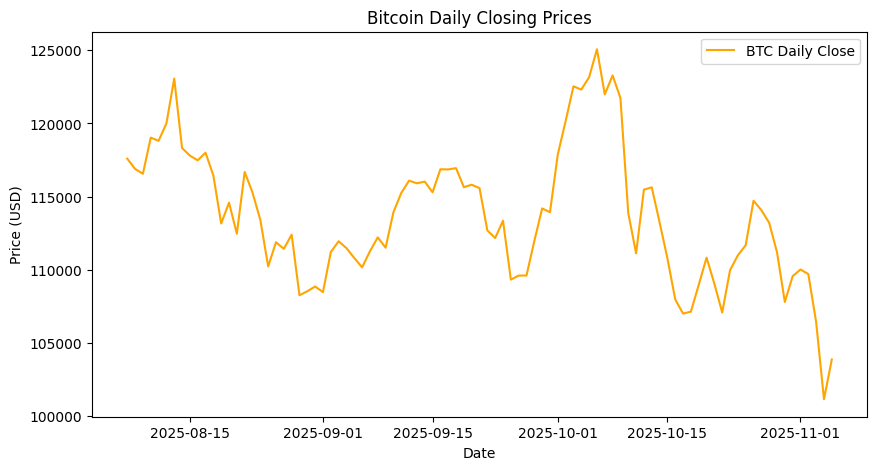

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(btc_daily["date"], btc_daily["BTC"], color="orange", label="BTC Daily Close")
plt.title("Bitcoin Daily Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [46]:
import numpy as np 
import math

# Sharp Ratio Grading Thresholds:
# Less than 1: Bad
# 1 – 1.99: Adequate/good
# 2 – 2.99: Very good
# Greater than 3: Excellent

# prices: array of prices
# rf: risk-free rate of return
def risk_return(prices, rf=0.04):
    returns = [((prices[i] - prices[i-1]) / prices[i-1]) for i in range(1, len(prices))]
    risk = np.std(returns)
    reward = np.mean(returns)
    return reward - rf / risk

print(risk_return(btc_daily["BTC"]))

# over 90 days
def volatility(prices):
    returns = [((prices[i] - prices[i-1]) / prices[i-1]) for i in range(1, len(prices))]
    average = sum(returns) / len(returns)
    diffs = []
    for daily_return in returns:
        diffs.append((daily_return - average)**2)
    sd = [math.sqrt(diff/len(returns)) for diff in diffs]
    crypto_volatility = [round(n * math.sqrt(365) * 100, 2) for n in sd]
    return crypto_volatility

btc_volatility = volatility(btc_daily["BTC"])
print(btc_volatility)



-2.0972718046750307
[0.96, 0.33, 4.5, 0.13, 2.24, 5.39, 7.51, 0.65, 0.31, 1.13, 2.42, 5.42, 2.77, 3.49, 7.8, 2.19, 3.02, 5.4, 3.26, 0.57, 1.99, 7.17, 0.75, 0.84, 0.47, 5.31, 1.58, 0.59, 0.98, 0.92, 2.24, 1.96, 1.02, 4.61, 2.57, 1.71, 0.07, 0.44, 1.03, 2.99, 0.22, 0.39, 1.99, 0.53, 0.17, 4.79, 0.69, 2.37, 6.9, 0.74, 0.25, 4.56, 4.25, 0.22, 7.22, 4.13, 4.22, 0.12, 1.63, 3.37, 4.73, 2.38, 2.28, 12.76, 4.61, 8.12, 0.51, 3.91, 4.13, 4.86, 1.57, 0.49, 3.68, 3.68, 3.0, 3.39, 5.67, 2.11, 1.5, 5.71, 0.88, 1.29, 3.33, 5.91, 3.53, 1.08, 0.33, 5.78, 9.73, 5.64]


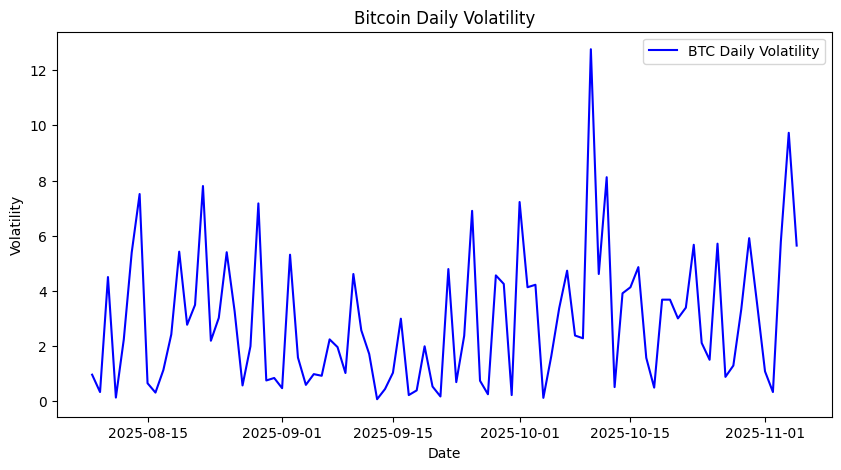

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(btc_daily["date"][1:], btc_volatility, color="blue", label="BTC Daily Volatility")
plt.title("Bitcoin Daily Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()
